In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import csv
from gensim.models import Word2Vec
import nltk
from sklearn.model_selection import train_test_split
import gc

# Loading the Train and Test Data in Text Format

In [2]:
#loading train data
train_df = pd.read_csv("train.csv")
train_df.head()

,text,sentiment
0,"Now, I won't deny that when I purchased this o...",neg
1,"The saddest thing about this ""tribute"" is that...",neg
2,Last night I decided to watch the prequel or s...,neg
3,I have to admit that i liked the first half of...,neg
4,I was not impressed about this film especially...,neg


In [3]:
#loading test data
test_df = pd.read_csv("test.csv")
test_df.head()

,text,sentiment
0,"My daughter liked it but I was aghast, that a ...",neg
1,I... No words. No words can describe this. I w...,neg
2,this film is basically a poor take on the old ...,neg
3,"This is a terrible movie, and I'm not even sur...",neg
4,First of all this movie is a piece of reality ...,pos


# Initial Data Exploration

In [4]:
#getting shape informations
print("Train Data shape: ", train_df.shape)
print("Test Data shape: ", test_df.shape)

Train Data shape:  (25000, 2)
Test Data shape:  (25000, 2)


- Both Sets have the same size of 25 000 data point, in total 50K labeled sentence

In [5]:
#looking for Null Values
print("Train Nan Values: ")
print(train_df.isnull().sum())

print("\nTest Nan Values: ")
print(test_df.isnull().sum())

Train Nan Values: 
text         0
sentiment    0
dtype: int64

Test Nan Values: 
text         0
sentiment    0
dtype: int64


- There is no Nan/Null Values in the both sets

In [6]:
#exploring the labels distribution
print(train_df['sentiment'].value_counts(), end="\n=================\n")
print(test_df['sentiment'].value_counts())

neg    12500
pos    12500
Name: sentiment, dtype: int64
neg    12500
pos    12500
Name: sentiment, dtype: int64


- The Distribution of positive and negative labels is 50/50 for both train and test set

In [7]:
# looking for sentence length informations
sent_len = train_df['text'].map(lambda x: len(x))
sent_len = pd.concat([sent_len, test_df['text'].map(lambda x: len(x))], ignore_index=True)
sent_len.head()

0     719
1    1857
2     945
3     913
4     985
Name: text, dtype: int64

In [8]:
#exploring senetence lengths 
print("The Maximum sentence length (words): ", sent_len.max())
print("The Minimum sentence length (words): ", sent_len.min())
print("The Median sentence length (words): ", sent_len.median())
print("The Average sentence length (words): ", sent_len.mean())
print("The Mode sentence length (words): ", sent_len.mode()[0])
print(f"95% Interval: [{np.percentile(sent_len.values, 2.5)} , {np.percentile(sent_len.values, 97.5)}] ")

The Maximum sentence length (words):  13704
The Minimum sentence length (words):  32
The Median sentence length (words):  970.0
The Average sentence length (words):  1309.43102
The Mode sentence length (words):  658
95% Interval: [279.0 , 4218.0] 


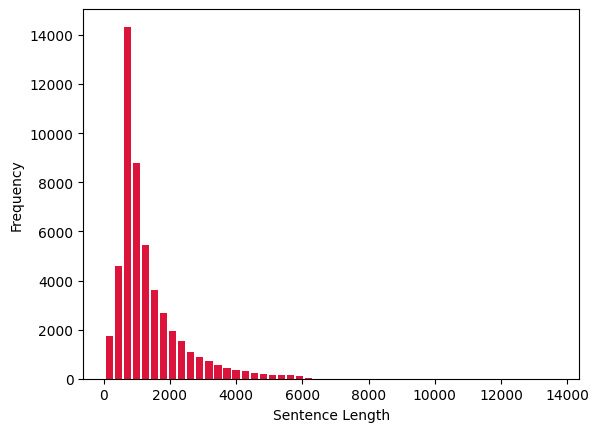

In [9]:
#graphically
plt.hist(sent_len, bins=50, rwidth=0.8, color="#DC143C")
plt.xlabel("Sentence Length")
plt.ylabel("Frequency")
plt.show()

- The sentence lengths vary greatly, however most of the values are between [279.0 , 4218.0]
- Max Value: **13704**
- Min Value: **32**
- Average Value: **1310**

In [10]:
#freeing memory
del sent_len
gc.collect()

6506

# Merging the datasets

- The train and Test sets are splitted 50/50, however we will instead use 80% for training, 10% evaluation, 10% testing
- 10% testing mean 5000 sentence to be evaluated, which should representative enough

In [11]:
total_dataset = pd.concat([train_df, test_df], ignore_index=True)
print(total_dataset.shape)
total_dataset.head()

(50000, 2)


,text,sentiment
0,"Now, I won't deny that when I purchased this o...",neg
1,"The saddest thing about this ""tribute"" is that...",neg
2,Last night I decided to watch the prequel or s...,neg
3,I have to admit that i liked the first half of...,neg
4,I was not impressed about this film especially...,neg


In [12]:
#freeing memory 
del train_df
del test_df
gc.collect()

32

# Creating the Vocabulary

In [13]:
#creating the Vocabulary of tokens while making everything lower case
tokens = [nltk.word_tokenize(review.lower()) for review in total_dataset['text']]

In [14]:
#checking the tokens
print(tokens[0])

['now', ',', 'i', 'wo', "n't", 'deny', 'that', 'when', 'i', 'purchased', 'this', 'off', 'ebay', ',', 'i', 'had', 'high', 'expectations', '.', 'this', 'was', 'an', 'incredible', 'out-of-print', 'work', 'from', 'the', 'master', 'of', 'comedy', 'that', 'i', 'so', 'enjoy', '.', 'however', ',', 'i', 'was', 'soon', 'to', 'be', 'disappointed', '.', 'apologies', 'to', 'those', 'who', 'enjoyed', 'it', ',', 'but', 'i', 'just', 'found', 'the', 'compleat', 'al', 'to', 'be', 'very', 'difficult', 'to', 'watch', '.', 'i', 'got', 'a', 'few', 'smiles', ',', 'sure', ',', 'but', 'the', 'majority', 'of', 'the', 'funny', 'came', 'from', 'the', 'music', 'videos', '(', 'which', 'i', "'ve", 'got', 'on', 'dvd', ')', 'and', 'the', 'rest', 'was', 'basically', 'filler', '.', 'you', 'could', 'tell', 'that', 'this', 'was', 'not', 'al', "'s", 'greatest', 'video', 'achievement', '(', 'that', 'honor', 'goes', 'to', 'uhf', ')', '.', 'honestly', ',', 'i', 'doubt', 'if', 'this', 'will', 'ever', 'make', 'the', 'jump', 'to

# Creating the Vector embeddings 

In [15]:
#training the word embeddings model
model = Word2Vec(tokens, vector_size=32, min_count=1, window=10)
model.save("w2vec_model")

In [16]:
#testing the model
print("Embeddings Similarity Test: ") 
print(model.wv.most_similar("man"))
print("\n=====================\n")
print("Vector Embeddings look Up: ")
print(model.wv['man'])
print("\n=====================\n")
print("Distance Embeddings Test: ")
vec = model.wv['king'] - model.wv['man'] + model.wv['woman']
print(model.wv.most_similar(vec))

Embeddings Similarity Test: 
[('doctor', 0.847237765789032), ('soldier', 0.7906357049942017), ('priest', 0.7846134305000305), ('woman', 0.7811627388000488), ('boy', 0.7722019553184509), ('monk', 0.7717127799987793), ('scientist', 0.7643183469772339), ('hero', 0.7588308453559875), ('psychopath', 0.7411227226257324), ('loser', 0.72895747423172)]


Vector Embeddings look Up: 
[-1.1851404  -0.43906406  5.208872   -0.10080391  0.21599168  2.2077792
  1.258881   -5.094253    4.9255214   0.20110843  2.018118   -1.7980326
 -0.39704356 -3.494662   -2.5181139   2.5706387   0.49877104 -2.3484836
  3.6635792  -2.8673155   2.0696483   3.3842154   1.9215056   5.9818435
 -2.5036747   3.0751133  -3.0857756  -4.679211   -3.607103   -2.2730782
 -0.48950604 -1.398945  ]


Distance Embeddings Test: 
[('queen', 0.7884224057197571), ('princess', 0.7397762537002563), ('enchanted', 0.732124388217926), ('carmen', 0.7168458700180054), ('carol', 0.7081384658813477), ('hilton', 0.6999144554138184), ('planche', 0.

In [17]:
len(model.wv.index_to_key)

164030

- The word embeddings seem reasonable enough for an american centric movie related dataset
- Each Vector is **64** dimension
- The vocabulary contain **164 030** unique token
- The only preprocessing done is making all reviews and tokens lower case to reduce vocab size

# Creating the Train, Dev, and Test sets

In [18]:
X = total_dataset['text'].copy()
Y = total_dataset['sentiment'].copy()

del total_dataset
gc.collect()

32

In [19]:
#transforming Y labels to 0: negative, 1:positive
Y.loc[Y == 'neg'] = 0
Y.loc[Y == 'pos'] = 1

In [20]:
Y.sample(5)

21205    0
16253    0
25411    1
38082    1
23923    0
Name: sentiment, dtype: object

In [21]:
#95% lenght of sequences
np.percentile([len(token) for token in tokens], 95)

714.0

In [22]:
# Transforming X texts into sequence of vectors for training
X_array = []
Y_array = []
index = 0
max_sequence = 714

for i, text_tokenized in enumerate(tokens):

    #using only 95% of the data to reduce sequence lengths 
    if len(text_tokenized) <= max_sequence:
        X_array.append([])
        for token in text_tokenized:
            vector_token = model.wv[token]
            X_array[index].append(vector_token)

        #padding the rest of the sequence with 0 vectors for Conv1D and to store as Numpy Array
        while len(X_array[index]) < max_sequence:
            X_array[index].append(np.zeros(32))
        
        Y_array.append(Y[i])
        index+=1

In [23]:
#freeing space
del X
del Y
gc.collect()

16

In [24]:
X_np = np.asarray(X_array)
Y_np = np.asarray(Y_array)

In [25]:
#freeing even more needed space
del X_array
del Y_array
gc.collect()

32

In [26]:
print(X_np.shape)
print(Y_np.shape)

(47502, 714, 32)
(47502,)


In [27]:
#saving the final data 
np.save("X_data.npy", X_np)
np.save("Y_data.npy", Y_np)

In [28]:
#freeing memory 
del X_np
del Y_np
gc.collect()

48